In [1]:
import numpy as np
import scipy as sp
%matplotlib notebook
import matplotlib.pyplot as plt
import sys, os
sys.path.append(os.environ['raco'])
sys.path.append(os.environ['rapl'])

from common import *
from plotcommon import *

<IPython.core.display.Javascript object>


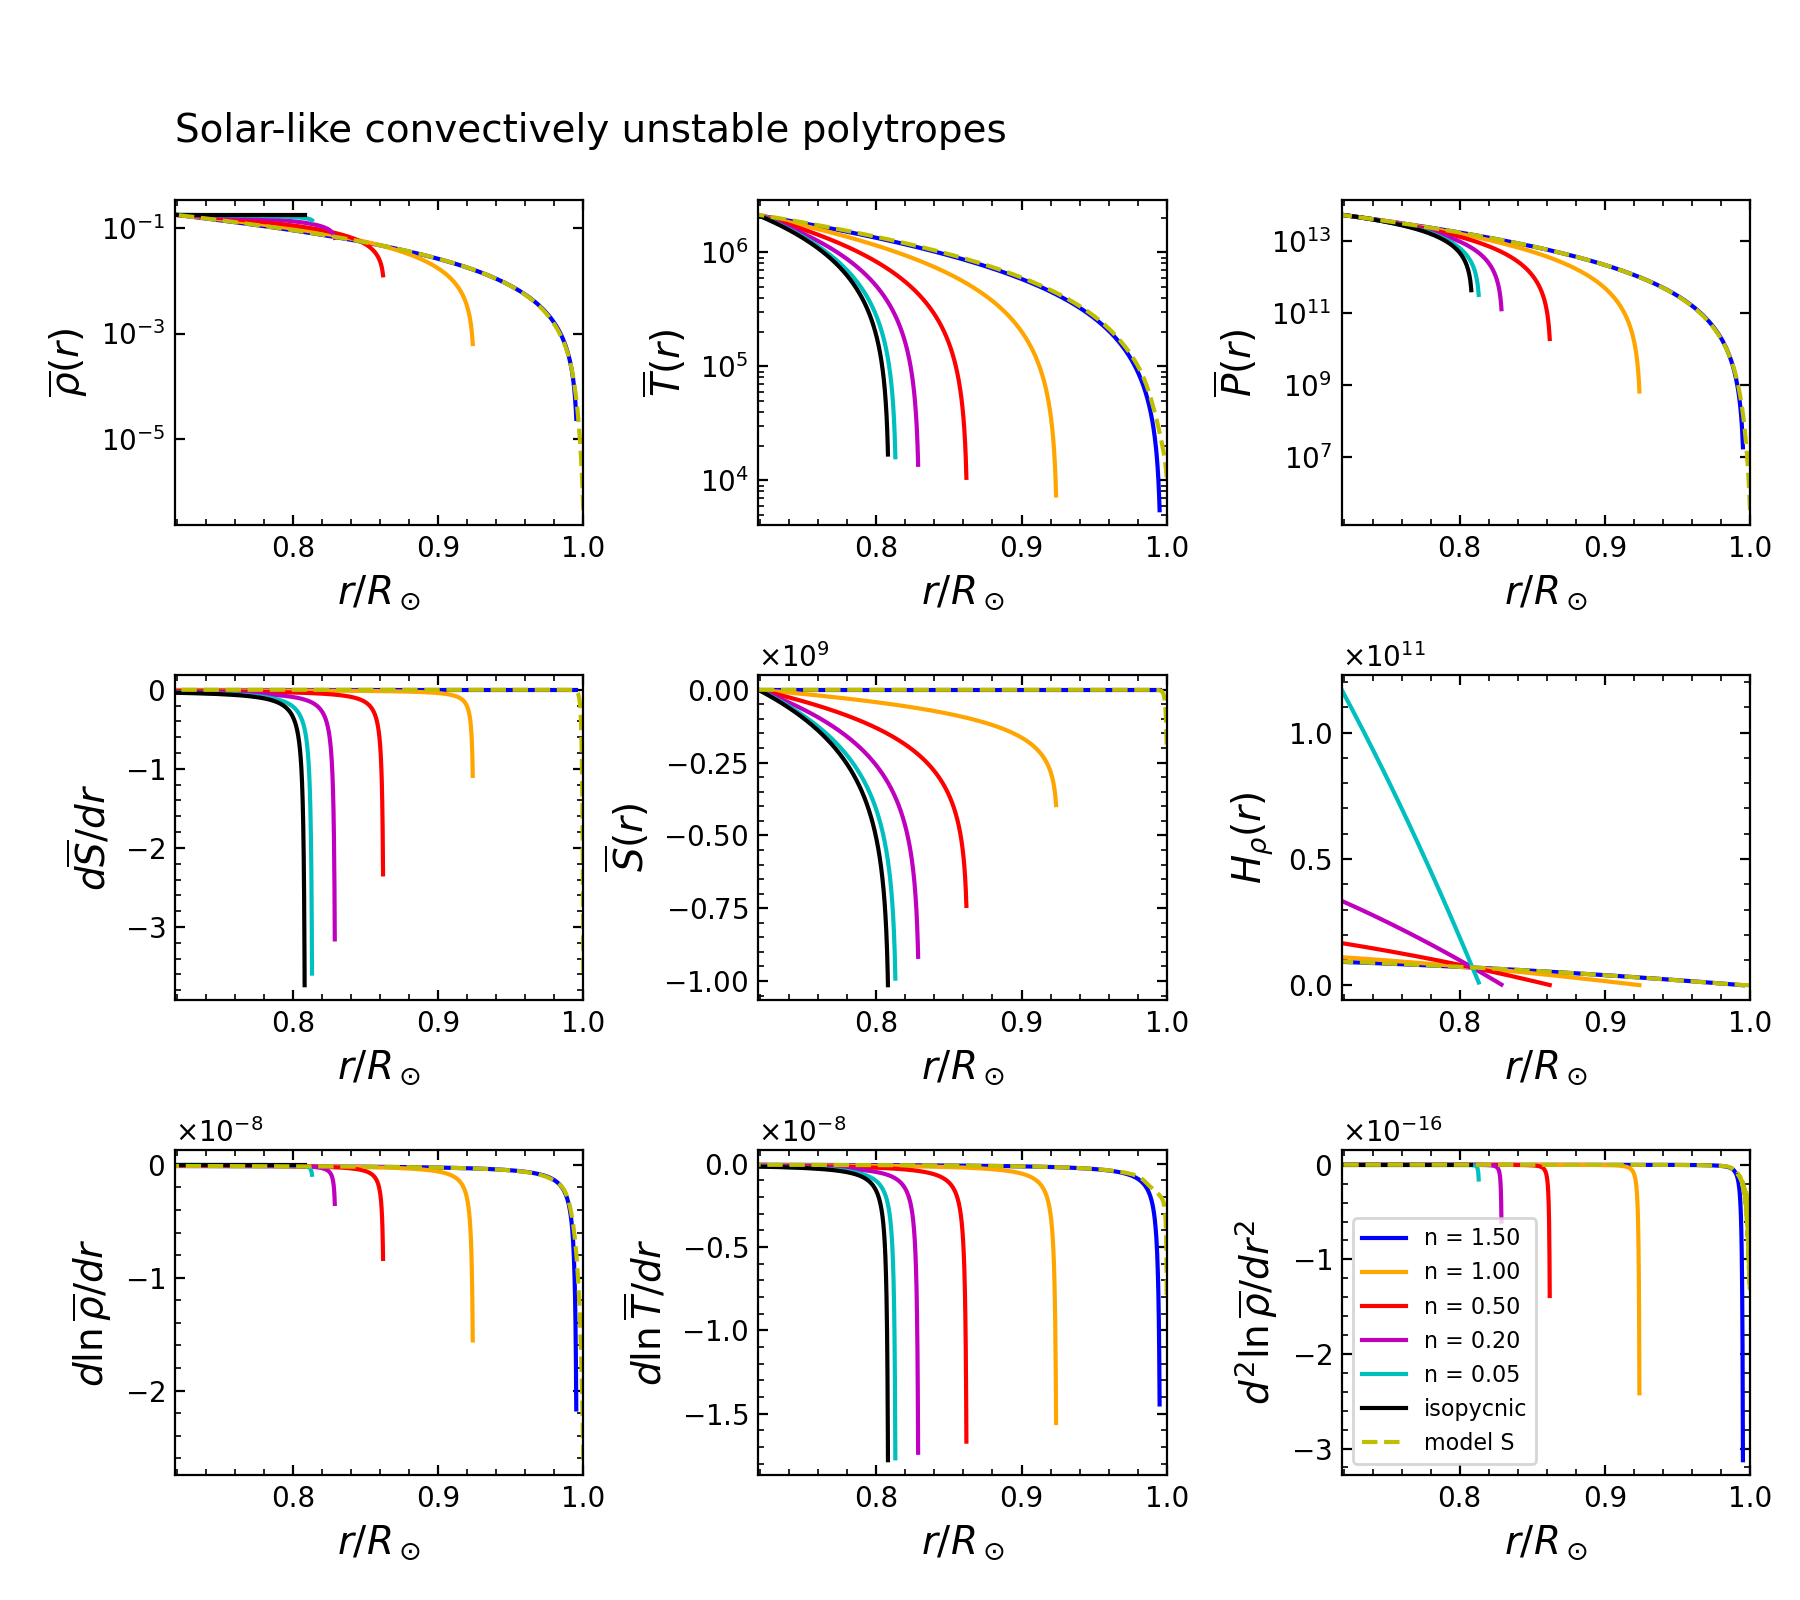

In [2]:
# pick fontsize
fontsize = 14

# define bottom radius, "integration radius", and number of grid points
rmin = sun.r_bcz
r0 = sun.r_bcz
nr = 1000

# Plot a bunch of reference states corresponding to different values 
# of the polytropic index n
nvals = np.array([1.5, 1.0, 0.5, 0.2, 0.05])

# define the constant b, gamma, ntilde
b = g_univ*msun/(sun.gas_constant*sun.tmp_bcz*r0)
gamma_monatomic = 5./3.
ntilde = 1./(gamma_monatomic - 1.)
    
count = 0
firstplot = True
for nval in nvals:
    # Define the constant a
    a = b/(nval + 1.)
    
    # define radius range
    if a > 1:
        rmax = (b/(b - (nval + 1.)))*r0
    else:
        rmax = np.infty
    if rmax > rsun:
        rmax = rsun
    lilbit = 0.001
    rmax = (1 - lilbit)*rmax
    
    rr = np.linspace(rmin, rmax, nr)
    
    # compute the polytrope
    zeta = a*r0/rr + (1. - a)

    tmp = sun.tmp_bcz*zeta
    rho = sun.rho_bcz*zeta**nval
    prs = sun.gas_constant*rho*tmp
    
    prefactor = sun.c_p * (nval - ntilde)/(ntilde + 1.)
    dsdr = prefactor / rr / ( 1 + ((1 - a)/a)*(rr/r0) )
    sbar = prefactor * (np.log(rr/r0) - np.log(a + (1-a)*(rr/r0)) )
    
    hrho = (1.0/nval) * rr * ( 1 + ((1 - a)/a)*(rr/r0) )

    dzeta = -a*r0/rr**2.
    d2zeta = 2.*a*r0/rr**3.
    dlnzeta = dzeta/zeta
    d2lnzeta = -dzeta**2./zeta**2. + d2zeta/zeta
    dlntmp = dlnzeta
    dlnrho = nval*dlnzeta
    d2lnrho = nval*d2lnzeta
    
    # now plot
    profiles = [rho, tmp, prs,
                dsdr, sbar, hrho,
                dlnrho, dlntmp, d2lnrho]

    if firstplot:
        nplots = len(profiles)
        nrow = 3
        ncol = nplots//nrow
        fig, axs, fpar = make_figure(nrow=nrow, ncol=ncol, width_inches=9., height_inches=8.)
        
        firstplot = False
    
    # plot the profiles
    for iplot in range(nplots):
        ax = axs.flatten()[iplot]
        ax.plot(rr/rsun, profiles[iplot], color = color_order[count], label='n = %.2f' %nval)
    
    count += 1

# add the isopycnic atmosphere (maximally unstable)

# define radius range
rmax = (b/(b - 1.))*r0
if rmax > rsun:
    rmax = rsun
lilbit = 0.001
rmax = (1 - lilbit)*rmax
rr = np.linspace(rmin, rmax, nr)
    
# get profiles
zero = np.zeros(nr)
tmp = sun.tmp_bcz*(b*(r0/rr) + (1 - b))
rho = sun.rho_bcz + zero
prs = sun.gas_constant*rho*tmp
dsdr = -sun.c_p*ntilde*b/(ntilde + 1.) * (1./rr) / ((1 - b)*(rr/r0) + b)
sbar = -sun.c_p*ntilde/(ntilde + 1.) * (np.log(rr/r0) - np.log((1. - b)*(rr/r0) + b))
dlnrho = zero
d2lnrho = zero
zeta = tmp/sun.tmp_bcz
dlntmp = -b*r0/rr**2. / zeta

# now plot
profiles = [rho, tmp, prs,
            dsdr, sbar, zero, # hrho = infinity; don't plot it
            dlnrho, dlntmp, d2lnrho]

for iplot in range(nplots):
    ax = axs.flatten()[iplot]
    if iplot != 5: # don't plot hrho
        ax.plot(rr/rsun, profiles[iplot], color = color_order[count], label='isopycnic')
count += 1
        
# add model S profiles in the form we need
fname = os.environ['notes'] + '/Model_S/Model_S.pkl'
model_S = get_dict(fname)
# d2 lnrho
d2lnrho = np.gradient(model_S['dlnrho'], model_S['rr'])
# entropy, integrate with simpson's rule
sbar = np.zeros(len(model_S['rr']))
for ir in range(len(model_S['rr'])):
    sbar[ir] = sp.integrate.simpson(model_S['dsdr'][:ir+1], model_S['rr'][:ir+1])
# zero out the entropy at r_bcz
rcut = sun.r_bcz
ircut = np.argmin(np.abs(model_S['rr'] - rcut))
sbar -= sbar[ircut]

# now plot
model_S_profiles = [model_S['rho'], model_S['tmp'], model_S['prs'],
                model_S['dsdr'], sbar, -1.0/model_S['dlnrho'],
                model_S['dlnrho'], model_S['dlntmp'], d2lnrho]

# plot the profiles
irmin = np.argmin(np.abs(model_S['rr'] - rmin))
irmax = np.argmin(np.abs(model_S['rr'] - rsun))
for iplot in range(nplots):
    ax = axs.flatten()[iplot]
    ax.plot(model_S['rr'][irmax:irmin+1]/rsun, model_S_profiles[iplot][irmax:irmin+1],\
            color = color_order[count], label='model S', linestyle='--')
count += 1
        
# tidy and label the axes
ylabels = [r'$\overline{\rho}(r)$', r'$\overline{T}(r)$', r'$\overline{P}(r)$',\
           r'$d\overline{S}/dr$', r'$\overline{S}(r)$', r'$H_{\rho}(r)$',
          r'$d\ln\overline{\rho}/dr$', r'$d\ln\overline{T}/dr$', r'$d^2\ln\overline{\rho}/dr^2$']

count = 0
for ax in axs.flatten():
    # label the axes
    ax.set_xlabel(r'$r/R_\odot$', fontsize=fontsize)
    ax.set_ylabel(ylabels[count], fontsize=fontsize)
    
    # set x axis limits
    ax.set_xlim(rmin/rsun, 1.)
    
    # make some logscale
    if count in [0, 1, 2]:
        ax.set_yscale('log')
    else:
        plt.sca(ax)
        plt.ticklabel_format(useMathText=True, axis='y', scilimits=(0,0))        
    
    # get ticks everywhere
    plt.sca(ax)
    plt.minorticks_on()
    plt.tick_params(top=True, right=True, direction='in', which='both')

    
    count += 1
    
fig.text(fpar['margin_left'] + fpar['sub_margin_left'], 1 - fpar['margin_top'],
         'Solar-like convectively unstable polytropes',\
         fontsize=fontsize, ha='left', va='bottom')
plt.legend(fontsize=8)


plt.savefig('figures/solar_CZ_polytropes_unstable.png')
#plt.close()

In [3]:
b

8.976394814007431